In [ ]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100
import tensorflow.keras.layers as L
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import numpy as np
import random

from PIL import Image
from random import randint
import time
import datetime
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

tf.__version__

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET = 'cifar'

In [ ]:
# Utility functions
def print_shapes(x_train, x_test, y_train, y_test):
  print(f"x_train: {x_train.shape}\n"\
      f"x_test: {x_test.shape}\n"\
      f"y_train: {y_train.shape}\n"\
      f"y_test: {y_test.shape}\n")

In [ ]:
# loading the dataset
if DATASET == 'mnist':
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
else:
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  
print_shapes(x_train, x_test, y_train, y_test)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)



In [ ]:
# # Cifar100
# labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
#                 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
#                 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
#                 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
#                 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
#                 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
#                 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
#                 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
#                 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
#                 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
#                 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
#                 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
#                 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
#                 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
#                 'worm']

# Cifar10
#labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# MNIST
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']



In [ ]:
# Pre-process data
if DATASET == 'mnist':
  img_rows, img_cols, channels =  28, 28, 1 
else:
  img_rows, img_cols, channels =  32, 32, 3

num_classes = len(labels)

x_train = x_train / 255
x_test = x_test / 255

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
class MyCNN(Sequential):
  def __init__(self,input_size,filter_size=128, kernel_size = (3,3), dropout_flg = True, dropout_rate = 0.3):
    super(MyCNN, self).__init__()
    self.input_size = input_size
    self.filter_size = filter_size
    self.kernel_size = kernel_size
    self.dropout_flg = dropout_flg
    self.dropout_rate = dropout_rate

    self.add(L.Conv2D(self.filter_size, kernel_size=self.kernel_size,padding='same', activation='relu', input_shape=self.input_size))
    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    self.add(L.Conv2D(self.filter_size/2, kernel_size=self.kernel_size,padding='same', activation='relu',input_shape=self.input_size))
    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    self.add(L.Conv2D(self.filter_size/2, kernel_size=self.kernel_size,padding='same', activation='relu'))
    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    self.add(L.Conv2D(self.filter_size/2, kernel_size=self.kernel_size,padding='same', activation='relu'))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
      
    self.add(L.Flatten())
    self.add(L.Dense(32))
    self.add(L.Dropout(0.2))
    self.add(L.Dense(num_classes, activation='softmax'))

In [ ]:
# Create and fit model
model = MyCNN((img_rows, img_cols, channels))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "my_cnn_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        73792     
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                     

In [ ]:
train_history = model.fit(x_train, y_train,
	validation_data=(x_test, y_test),
	batch_size=64,
	epochs=10,
	verbose=1)

Epoch 1/10
782/782 [==============================] - 315s 402ms/step - loss: 0.0755 - accuracy: 0.3624 - val_loss: 0.0727 - val_accuracy: 0.4666
Epoch 2/10
782/782 [==============================] - 310s 397ms/step - loss: 0.0621 - accuracy: 0.5120 - val_loss: 0.0649 - val_accuracy: 0.5180
Epoch 3/10
782/782 [==============================] - 308s 394ms/step - loss: 0.0562 - accuracy: 0.5698 - val_loss: 0.0551 - val_accuracy: 0.6255
Epoch 4/10
782/782 [==============================] - 314s 401ms/step - loss: 0.0518 - accuracy: 0.6062 - val_loss: 0.0549 - val_accuracy: 0.6045
Epoch 5/10
782/782 [==============================] - 310s 396ms/step - loss: 0.0495 - accuracy: 0.6292 - val_loss: 0.0544 - val_accuracy: 0.5941
Epoch 6/10
782/782 [==============================] - 313s 400ms/step - loss: 0.0473 - accuracy: 0.6471 - val_loss: 0.0495 - val_accuracy: 0.6469
Epoch 7/10
782/782 [==============================] - 317s 406ms/step - loss: 0.0454 - accuracy: 0.6640 - val_loss: 0.0486 -

In [ ]:
def _plot(tr_history = train_history):
  fig, axis = plt.subplots(1, 2,figsize=(20, 8))
  # plotting loss
  axis[0].plot(tr_history.history['loss'], label="loss",color='red')
  axis[0].set_title("Loss per epoch for training set")
  axis[1].plot(tr_history.history['accuracy'], label="accuracy",color='green')
  axis[1].set_title("Accuracy per epoch for training set")
  # # plotting accuracy
  # axis[1,0].plot(tr_history.history['accuracy'], label="accuracy",color='green')
  # axis[1, 0].set_title("Accuracy per epoch for training set")
  # axis[1,1].plot(tr_history.history['val_accuracy'], label="val_accuracy",color='green')
  # axis[1, 1].set_title("Accuracy per epoch for validation set")

  plt.show()

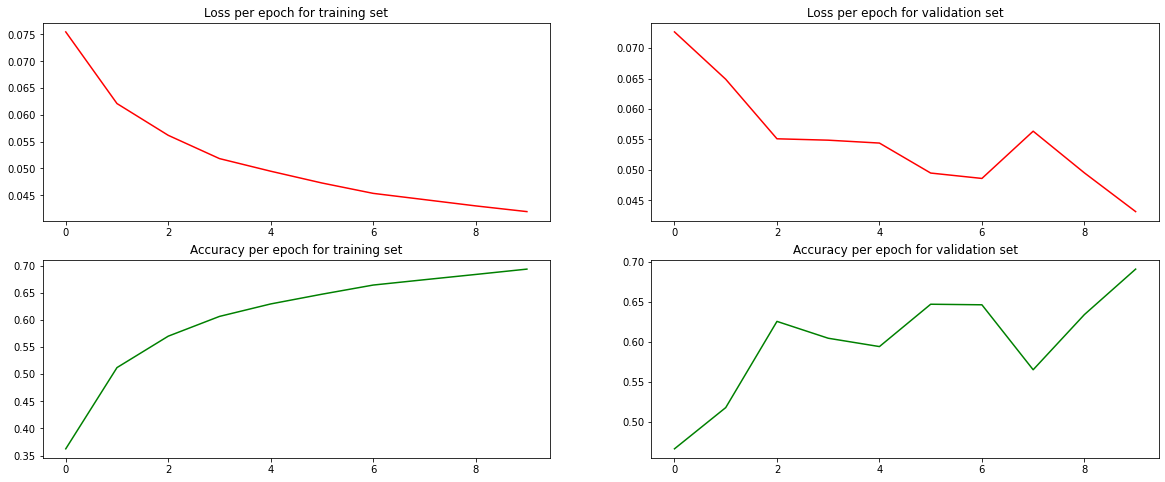

In [ ]:
_plot()

In [ ]:
# Assess base model accuracy on regular images
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.043169599026441574, 0.6906999945640564]


In [ ]:
folder_id = time.strftime('[%d%m%Y]_%H%M%s', time.localtime())
dir_path = "/content/drive/MyDrive/Thesis_notebooks/keras_boundary_attack/images"
os.mkdir(os.path.join(dir_path, folder_id))

In [ ]:
def process_img(image,adversarial_label,squeeze = False, folder = folder_id):
  """Export image file."""
  label = adversarial_label
  print("Labeling from function",label)
  
  cmap = plt.cm.jet
  id_no = time.strftime('%Y%m%d_%H%M%S', datetime.datetime.now().timetuple())
  if DATASET == 'mnist':
    norm = plt.Normalize(vmin=image.reshape((img_rows, img_cols)).min(), vmax=image.reshape((img_rows, img_cols)).max())
    # map the normalized data to colors
    # image is now RGBA (512x512x4) 
    _image = cmap(norm(image.reshape((img_rows, img_cols))))
    # Save with predicted label for image (may not be adversarial due to uint8 conversion)
    plt.imsave(os.path.join("/content/drive/MyDrive/Thesis_notebooks/keras_boundary_attack/images", folder,"{}_{}.png".format(id_no, label)), _image)

  else:
    plt.figure(figsize=(3,3))
    _image = (1/(2*1.050000000745058)) * image + 0.35
    print(np.max(image))
    plt.imsave(os.path.join("/content/drive/MyDrive/Thesis_notebooks/keras_boundary_attack/images", folder,"{}_{}.png".format(id_no, label)),_image.reshape(img_rows, img_cols, channels))

In [ ]:
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps,clip_value_max=eps)

In [ ]:
EPS = 2 / 255.0
LR = 0.1
optimizer = Adam(learning_rate=LR)
sccLoss = SparseCategoricalCrossentropy()
losses_per_image = []

In [ ]:
def generate_adversaries(model, baseImage, label, epochs=50):
  
  # iterate over the number of steps
  for step in range(0, epochs):
    baseImage = tf.cast(baseImage, tf.float32)
    delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
    # explicitly indicate that our perturbation vector should
 		# be tracked for gradient updates
    with tf.GradientTape() as tape:
      tape.watch(baseImage)
      # add our perturbation vector to the base image
      adversary = baseImage + delta
      # run this newly constructed image tensor through our
 			# model and calculate the loss
      pred = model(adversary)
      loss = tf.keras.losses.MSE(label, pred)
      # if step % 5 == 0:
      #    print("step: {}, loss: {}...".format(step,loss[0])) 

    # update the weights, clip the perturbation vector, and
 		# update its value
    gradients = tape.gradient(loss, baseImage)
    delta.assign_add(clip_eps(delta, eps = EPS))
    optimizer.apply_gradients([(gradients,delta)])
    signed_grad = tf.sign(gradients)

  losses_per_image.append(loss[0])
  return signed_grad


In [ ]:
# Adversarial data generator
def generate_adversarials(model, batch_size):
    while True:
        x = []
        y = []
        true_images = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            true_images.append(image)

            perturbations = generate_adversaries(model, image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        true_images = np.asarray(true_images).reshape((batch_size, img_rows, img_cols, channels))
        
        yield x, y, true_images

In [ ]:
from tensorflow.keras.losses import MSE

def generate_image_adversary(model, image, label, eps=2 / 255.0):
	# cast the image
	image = tf.cast(image, tf.float32)
	# record our gradients
	with tf.GradientTape() as tape:
		# explicitly indicate that our image should be tacked for
		# gradient updates
		tape.watch(image)
		# use our model to make predictions on the input image and
		# then compute the loss
		pred = model(image)
		loss = MSE(label, pred)
	# calculate the gradients of loss with respect to the image, then
	# compute the sign of the gradient
	gradient = tape.gradient(loss, image)
	signedGrad = tf.sign(gradient)
	# construct the image adversary
	adversary = (image + (signedGrad * eps)).numpy()
	# return the image adversary to the calling function
	return adversary

In [ ]:
def generate_adversarial_batch(model, total, images, labels, dims,eps=0.01):
	# unpack the image dimensions into convenience variables
  (h, w, c) = dims
  while True:
      # initialize our perturbed images and labels
    perturbImages = []
    perturbLabels = []
      # randomly sample indexes (without replacement) from the
      # input data
    idxs = np.random.choice(range(0, len(images)), size=total,replace=False)
  		# loop over the indexes
    for i in idxs:
        # grab the current image and label
      image = images[i]
      label = labels[i]
        # generate an adversarial image
      adversary = generate_image_adversary(model,image.reshape(1, h, w, c), label, eps=eps)
        # update our perturbed images and labels lists
      perturbImages.append(adversary.reshape(h, w, c))
      perturbLabels.append(label)
      # yield the perturbed images and labels
    yield (np.array(perturbImages), np.array(perturbLabels))

In [ ]:
(loss, acc) = model.evaluate(x=x_test, y=y_test, verbose=0)
print("[INFO] normal testing images:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))
# generate a set of adversarial from our test set
print("[INFO] generating adversarial examples with FGSM...\n")
(advX, advY) = next(generate_adversarial_batch(model, len(x_test),x_test, y_test, (img_rows, img_cols, channels), eps=0.1))
# re-evaluate the model on the adversarial images
(loss, acc) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial testing images:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

[INFO] normal testing images:
[INFO] loss: 0.0432, acc: 0.6907

[INFO] generating adversarial examples with FGSM...

[INFO] adversarial testing images:
[INFO] loss: 0.1322, acc: 0.0245



In [ ]:
# lower the learning rate and re-compile the model (such that we can
# fine-tune it on the adversarial images)
print("[INFO] re-compiling model...")
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])
# fine-tune our CNN on the adversarial images
print("[INFO] fine-tuning network on adversarial examples...")
train_history = model.fit(advX, advY,
													batch_size=64,
													epochs=10,
													verbose=1)

[INFO] re-compiling model...
[INFO] fine-tuning network on adversarial examples...
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


157/157 [==============================] - 66s 412ms/step - loss: 2.7116 - accuracy: 0.0937
Epoch 2/10
157/157 [==============================] - 65s 415ms/step - loss: 2.2111 - accuracy: 0.1417
Epoch 3/10
157/157 [==============================] - 66s 419ms/step - loss: 2.1485 - accuracy: 0.1701
Epoch 4/10
157/157 [==============================] - 65s 413ms/step - loss: 2.0968 - accuracy: 0.1933
Epoch 5/10
157/157 [==============================] - 63s 398ms/step - loss: 2.0471 - accuracy: 0.2086
Epoch 6/10
157/157 [==============================] - 63s 404ms/step - loss: 2.0188 - accuracy: 0.2308
Epoch 7/10
157/157 [==============================] - 62s 397ms/step - loss: 2.0066 - accuracy: 0.2335
Epoch 8/10
157/157 [==============================] - 62s 393ms/step - loss: 1.9808 - accuracy: 0.2464
Epoch 9/10
157/157 [==============================] - 63s 403ms/step - loss: 1.9601 - accuracy: 0.2541
Epoch 10/10
157/157 [==============================] - 63s 404ms/step - loss: 1.9428

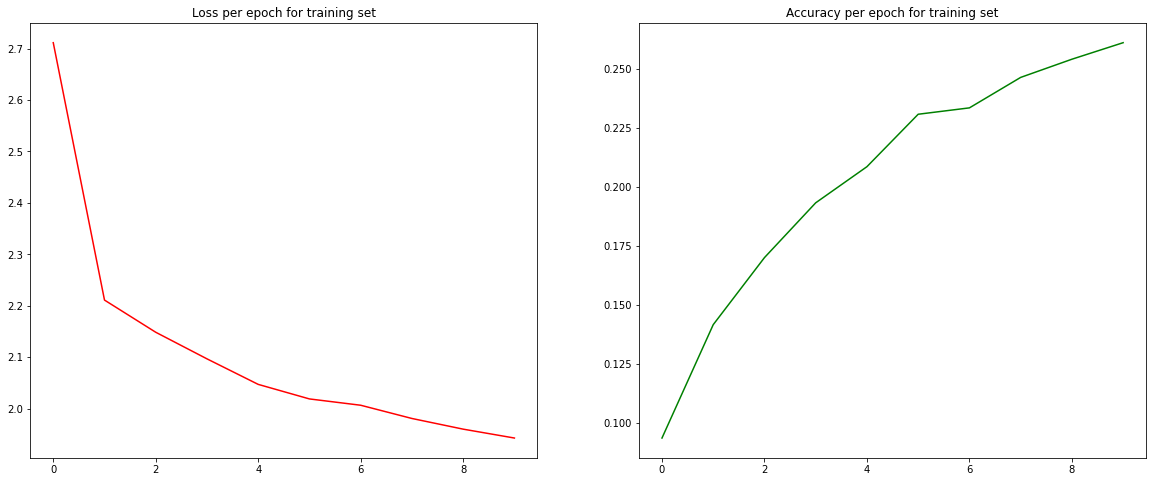

In [ ]:
_plot(train_history)

In [ ]:
(loss, acc) = model.evaluate(x=x_test, y=y_test, verbose=0)
print("")
print("[INFO] normal testing images *after* fine-tuning:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))
# do a final evaluation of the model on the adversarial images
(loss, acc) = model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial images *after* fine-tuning:")
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))


[INFO] normal testing images *after* fine-tuning:
[INFO] loss: 2.0781, acc: 0.2211

[INFO] adversarial images *after* fine-tuning:
[INFO] loss: 2.0720, acc: 0.2241


In [ ]:
Epoch 1/10
782/782 [==============================] - 315s 402ms/step - loss: 0.0755 - accuracy: 0.3624 - val_loss: 0.0727 - val_accuracy: 0.4666
Epoch 2/10
782/782 [==============================] - 310s 397ms/step - loss: 0.0621 - accuracy: 0.5120 - val_loss: 0.0649 - val_accuracy: 0.5180
Epoch 3/10
782/782 [==============================] - 308s 394ms/step - loss: 0.0562 - accuracy: 0.5698 - val_loss: 0.0551 - val_accuracy: 0.6255
Epoch 4/10
782/782 [==============================] - 314s 401ms/step - loss: 0.0518 - accuracy: 0.6062 - val_loss: 0.0549 - val_accuracy: 0.6045
Epoch 5/10
782/782 [==============================] - 310s 396ms/step - loss: 0.0495 - accuracy: 0.6292 - val_loss: 0.0544 - val_accuracy: 0.5941
Epoch 6/10
782/782 [==============================] - 313s 400ms/step - loss: 0.0473 - accuracy: 0.6471 - val_loss: 0.0495 - val_accuracy: 0.6469
Epoch 7/10
782/782 [==============================] - 317s 406ms/step - loss: 0.0454 - accuracy: 0.6640 - val_loss: 0.0486 - val_accuracy: 0.6462
Epoch 8/10
782/782 [==============================] - 308s 393ms/step - loss: 0.0442 - accuracy: 0.6738 - val_loss: 0.0564 - val_accuracy: 0.5652
Epoch 9/10
782/782 [==============================] - 311s 398ms/step - loss: 0.0430 - accuracy: 0.6835 - val_loss: 0.0495 - val_accuracy: 0.6340
Epoch 10/10
782/782 [==============================] - 310s 396ms/step - loss: 0.0419 - accuracy: 0.6934 - val_loss: 0.0432 - val_accuracy: 0.6907

Text(0.5, 1.0, 'Accuracy per epoch (shown as time duration (s)), after - adversarial training')

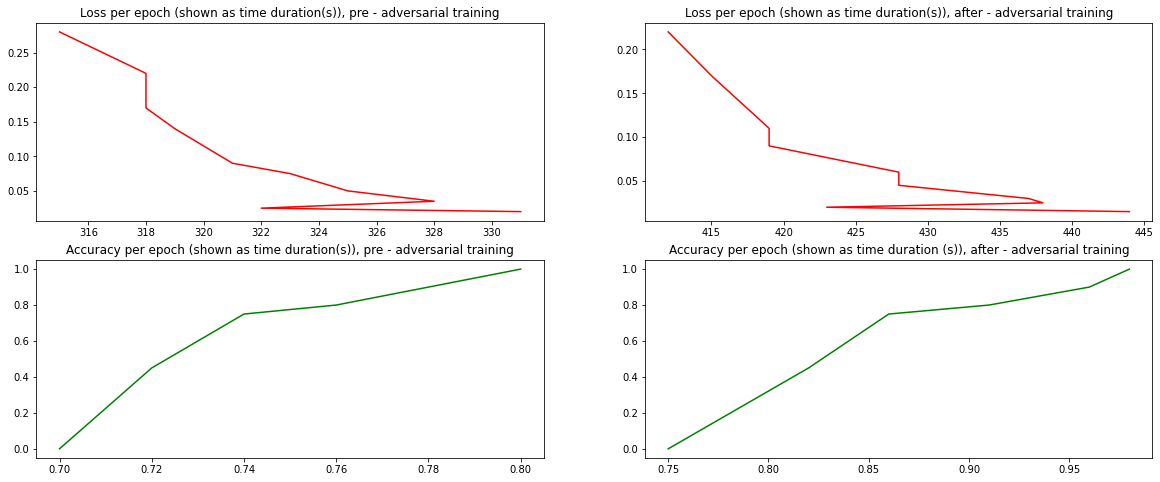

In [ ]:
import matplotlib.pyplot as plt


fig, axis = plt.subplots(2, 2,figsize=(20, 8))
# plotting loss
x_data = [315, 318, 318, 319, 321, 323, 325, 328, 322, 331]
y_data = [0.28, 0.22, 0.17, 0.14, 0.09, 0.075, 0.05, 0.035, 0.025, 0.02]

axis[0,0].plot(x_data, y_data, label="loss",color='red')
axis[0,0].set_title("Loss per epoch (shown as time duration(s)), pre - adversarial training")

x_data = [412, 415, 419, 419, 428, 428, 437, 438, 423, 444]
y_data = [0.22, 0.17, 0.11, 0.09, 0.06, 0.045, 0.03, 0.025, 0.02, 0.015]

axis[0,1].plot(x_data, y_data, label="loss",color='red')
axis[0,1].set_title("Loss per epoch (shown as time duration(s)), after - adversarial training")

x_data = [0.70, 0.72, 0.74, 0.76, 0.78, 0.80]
y_data = [0, 0.45, 0.75, 0.8, 0.9, 1]

axis[1,0].plot(x_data, y_data, color = 'green')
axis[1,0].set_title("Accuracy per epoch (shown as time duration(s)), pre - adversarial training")

x_data = [0.75, 0.82, 0.86, 0.91, 0.96, 0.98]
y_data = [0, 0.45, 0.75, 0.8, 0.9, 1]

axis[1,1].plot(x_data, y_data, color = 'green')
axis[1,1].set_title("Accuracy per epoch (shown as time duration (s)), after - adversarial training")